In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import torch

# **Ladle furnace benchmark: inference**

In this example, we'll be analysing different **fill-level inference methods** for the task described in our initial [TomOpt paper](https://arxiv.org/abs/2309.14027). We aim at demonstrating the **capability** of the designed methods **to infer the fill level of a furnace ladle containing melted steel**. 


In [3]:
NAME = 'ladle_furnace_inference'

## **Parameters of the simulation scenario**

In [4]:
Simulations = 100 # number of simulations
Time = 5 # muography measurement time of a single simulation [min]
Flux = 6845 # considered flux of muons [muons/(min*m^2)]

# muon hit detection resolution [m]
Resolution = 0.00001 # 0,01 mm (really high resolution)
# Resolution = 0.001 # 1 mm (standard muography detector)

# Detection panel span [m]
PanelSpan = 0.7
# PanelSpan = 0.9

# Vertical positions of the panels [m]
PanelZpos = [1.00, 0.90, 0.80, 0.20, 0.10, 0.00] # Big gap = 0.1
# PanelZpos = [0.90, 0.85, 0.80, 0.20, 0.15, 0.10] # Small gap = 0.05
# PanelZpos = [0.90, 0.85, 0.80, 0.20, 0.10, 0.00] # Not centred (Upper small gap, lower big gap)

We'll begin by defining our **volume**, consisting of the **detectors** and **passive volume**. 

In [5]:
from tomopt.volume import Volume

ModuleNotFoundError: No module named 'torch._prims_common'

In [9]:
from tomopt.benchmarks.ladle_furnace import get_detector
#from tomopt.benchmarks.ladle_furnace import get_detector_res1e5_BigGap
#from tomopt.benchmarks.ladle_furnace import get_detector_res1e3_BigGap
#from tomopt.benchmarks.ladle_furnace import get_detector_res1e3_SmallGap
#from tomopt.benchmarks.ladle_furnace import get_detector_res1e3_NotCentred

In [22]:
PanelZ = [1.80, 1.65, 1.50, 0.30, 0.15, 0.00] # Big gap

volume_BigGapHighRes = Volume(get_detector(device=DEVICE, span=0.9, res=1e5, panelZpositions=PanelZ), budget=6)
volume_BigGapHighRes

volume_BigGap = Volume(get_detector(device=DEVICE, span=0.9, res=1e3, panelZpositions=PanelZ), budget=6)
volume_BigGap

PanelZ = [1.60, 1.55, 1.50, 0.30, 0.25, 0.20] # Small gap

volume_SmallGap = Volume(get_detector(device=DEVICE, span=0.9, res=1e3, panelZpositions=PanelZ), budget=6)
volume_SmallGap

PanelZ = [1.60, 1.55, 1.50, 0.30, 0.15, 0.00] # Not centred

volume_NotCentred = Volume(get_detector(device=DEVICE, span=0.9, res=1e3, panelZpositions=PanelZ), budget=6)
volume_NotCentred

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.6000]), and xy span tensor([1., 1.]) with budget scale 1.1111111640930176
        (1): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.5500]), and xy span tensor([1., 1.]) with budget scale 1.1111111640930176
        (2): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.5000]), and xy span tensor([1., 1.]) with budget scale 1.1111111640930176
      )
    )
    (1): PassiveLayer located at z=tensor([1.4000])
    (2): PassiveLayer located at z=tensor([1.3000])
    (3): PassiveLayer located at z=tensor([1.2000])
    (4): PassiveLayer located at z=tensor([1.1000])
    (5): PassiveLayer located at z=tensor([1.])
    (6): PassiveLayer located at z=tensor([0.9000])
    (7): PassiveLay

We can visualise the layout of this in 3D. Note the closeness of the panels, and their offset from the passive volume. We do not expect this detector to perform well, but we can optimise it to a better configuration.

<IPython.core.display.Javascript object>


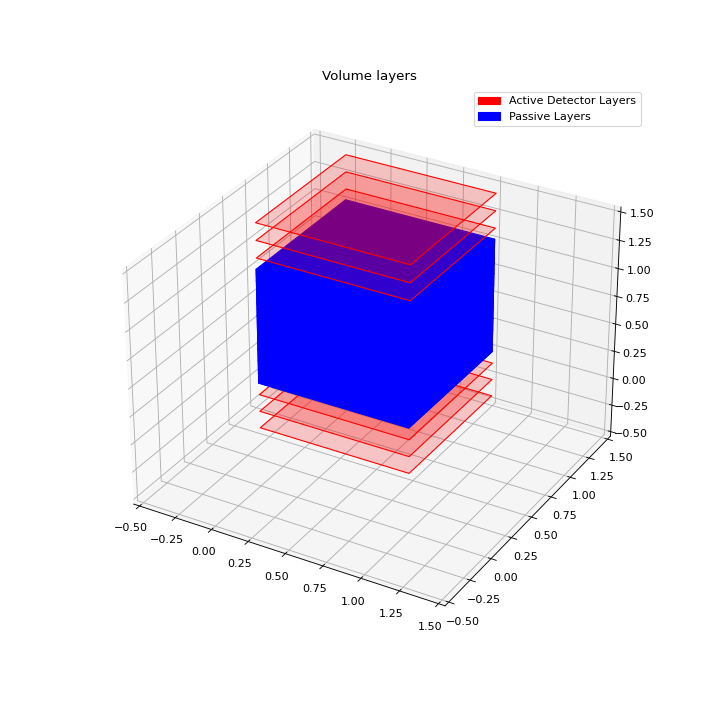

In [23]:
%matplotlib notebook
volume_BigGap.draw(xlim=(-0.5,1.5), ylim=(-0.5,1.5), zlim=(-0.5,1.5))

<IPython.core.display.Javascript object>


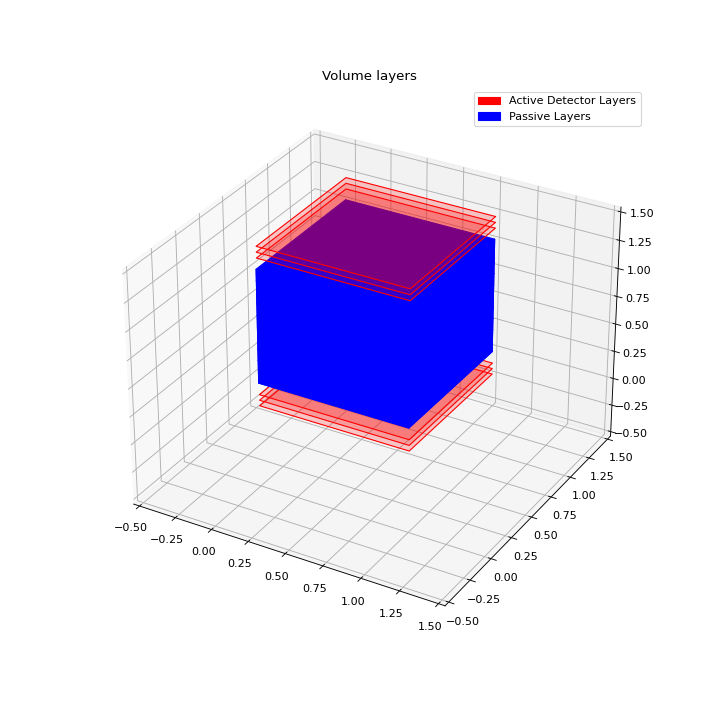

In [20]:
%matplotlib notebook
volume_SmallGap.draw(xlim=(-0.5,1.5), ylim=(-0.5,1.5), zlim=(-0.5,1.5))

<IPython.core.display.Javascript object>


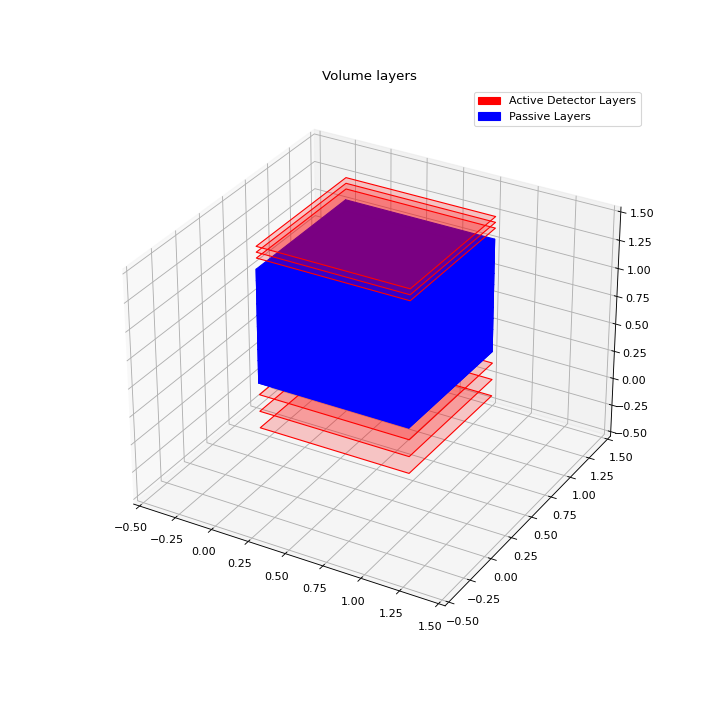

In [21]:
%matplotlib notebook
volume_NotCentred.draw(xlim=(-0.5,1.5), ylim=(-0.5,1.5), zlim=(-0.5,1.5))

In [8]:
%matplotlib inline

### **B - Passive volume generation**

Now we'll need to define how to **generate** example **passive volumes**. The furnace ladle is nade of several elements:

 - **Ladle**: a $1\times1\times1 \:[\text{m}^3]$ bucket made of solid steel.

 - **Liquid steel**: The ladle is filled with a **random amount** of liquid steel.

 - **Slag**: Above the liquid steel is a **layer** of **slag**, with a lower density that liquid steel.

 - **Air**: The rest of the ladle is filled with air.


`LadleFurnacePassiveGenerator` class will create layouts based on varying fill-heights of a furnace ladle, with varying levels of slag.

In [9]:
from tomopt.benchmarks.ladle_furnace import LadleFurnacePassiveGenerator

In [10]:
passive_gen = LadleFurnacePassiveGenerator(volume)

For a single training epoch, we'll generate 5 volumes at a range of fill-heights. The 10cm of slag will be present for ever volume.

In [11]:
N_PASSIVES_PER_H = 5

In [12]:
HEIGHTS = [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]

In [13]:
from tomopt.optimisation import PassiveYielder

In [14]:
trn_passives = PassiveYielder([passive_gen._generate(fixed_mat_z=h, fixed_slag_z=h+0.1)
                               for _ in range(N_PASSIVES_PER_H) for h in HEIGHTS])

Let's visualise one these volume layouts by repurposing one of the visualisers in TomOpt

In [15]:
f,t = trn_passives.passives[20]
volume.load_rad_length(f, t)

In [16]:
from tomopt.plotting import plot_pred_true_x0
from tomopt.utils import x0targs_to_classtargs
from tomopt.core import X0

In [17]:
x02id = {X0['air']:0, X0['slag']:1, X0['hot liquid steel']:2, X0['steel']:3}

In [18]:
x02id

{303.9: 0, 0.08211: 1, 0.01991: 2, 0.01782: 3}

In [19]:
true = volume.get_rad_cube()
class_true = x0targs_to_classtargs(true, x02id)

In [20]:
import numpy as np

Absolute fill height tensor([1.])


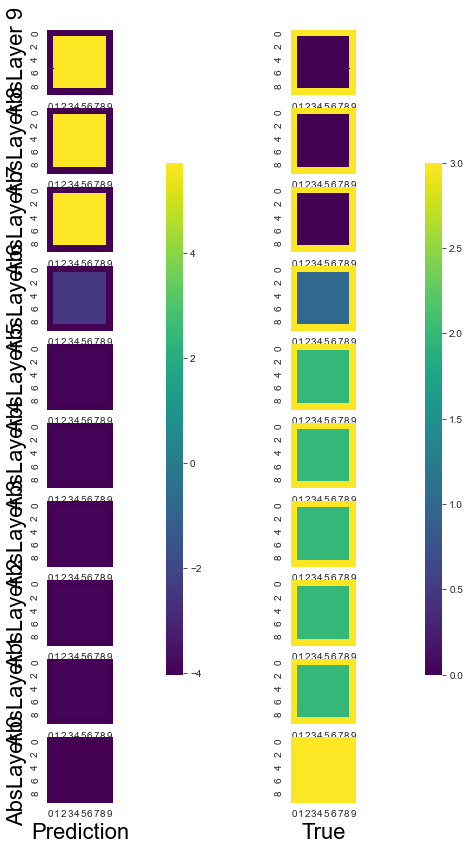

In [21]:
print("Absolute fill height", t)
plot_pred_true_x0(np.log(true), class_true)

Ignoring the predicted and true labels, on the right is the layers of the ladle, coloured by voxel material: 

 - Yellow = **ladle** (steel) 
 - Green = **liquid steel** 
 - Blue = **Slag** 
 - Purple = **Air**

On the left is the same set of layers, but coloured by material log_10 of the X0. We can see that the metals have very similar X0, but they are slightly distinguishable from the slag.

### **C - Optimiser setup**

We'll define separate optimisers for panels above and below the passive volume, and each of their xy, or z positions. Additionally, we'll have a separate optimiser to adjust the budget distribution to the panels.

In [22]:
lu, ld = volume.get_detectors()[0], volume.get_detectors()[1]
opts = {'xy_pos_upper':torch.optim.SGD((p.xy for p in lu.panels), lr=3.0),
        'z_pos_upper':torch.optim.SGD((p.z for p in lu.panels), lr=0.01),
        'xy_pos_lower':torch.optim.SGD((p.xy for p in ld.panels), lr=3.0),
        'z_pos_lower':torch.optim.SGD((p.z for p in ld.panels), lr=0.01),
        'budget_weights':torch.optim.SGD((p for p in [volume.budget_weights]), lr=0.01)
       }

Now we'll create a volume wrapper to contain the optimisers, volume, and inference methods. The inference method is described in the paper, and uses the mean of the POCA z-positions to provide a prediction of the fill-height.

In [23]:
from tomopt.optimisation import ArbVolumeWrapper, VolumeMSELoss
from tomopt.benchmarks.ladle_furnace import PocaZLadleFurnaceFillLevelInferrer
from functools import partial

In [24]:
wrapper = ArbVolumeWrapper(volume,
                             opts=opts,
                             loss_func=VolumeMSELoss(target_budget=None),
                             partial_volume_inferrer=partial(PocaZLadleFurnaceFillLevelInferrer, smooth=1.0))

### **D - Inference**

Let's evaluate the initial performance of our detector. We'll do this on a test dataset of 100 passive volumes at each of our specified heights.

In [25]:
test_passives = PassiveYielder([passive_gen._generate(fixed_mat_z=h, fixed_slag_z=h+0.1)
                               for _ in range(100//len(HEIGHTS)) for h in HEIGHTS])
len(test_passives)

96

For evaluation of the predictions, we'll want to also have access to the the true fill-height. We'll use the `VolumeTargetPredHandler` to ensure this information isn't lost.

In [26]:
from tomopt.optimisation import VolumeTargetPredHandler, MuonResampler

In [27]:
preds = wrapper.predict(test_passives,
                n_mu_per_volume=1000,
                mu_bs=1000,
                pred_cb=VolumeTargetPredHandler(),
                cbs=[MuonResampler()])

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


The returned predictions consist of pairs of predicted and true fill-heights. Lets plot out the bias and MSE:

In [28]:
preds[:5]

[(array([0.7659905], dtype=float32), array([0.6], dtype=float32)),
 (array([0.7890348], dtype=float32), array([0.7], dtype=float32)),
 (array([0.7853464], dtype=float32), array([0.8], dtype=float32)),
 (array([0.83466244], dtype=float32), array([0.9], dtype=float32)),
 (array([0.81884557], dtype=float32), array([1.], dtype=float32))]

In [29]:
import pandas as pd

In [30]:
df_start = pd.DataFrame(np.array(preds).flatten().reshape(-1,2), columns=['pred', 'gen_target'])
df_start['gen_target'] = volume.passive_size*((df_start.gen_target/volume.passive_size)//1)
df_start['bias'] = (df_start.gen_target-df_start.pred)
df_start['mse'] = df_start.bias**2

In [31]:
df_start.mse.mean()

0.044784646

In [32]:
!mkdir {NAME}_plots

mkdir: ladle_furnace_plots: File exists


In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
from tomopt.plotting import STYLE, TK_COL, TK_SZ, LBL_COL, LBL_SZ, W_MID, H_MID

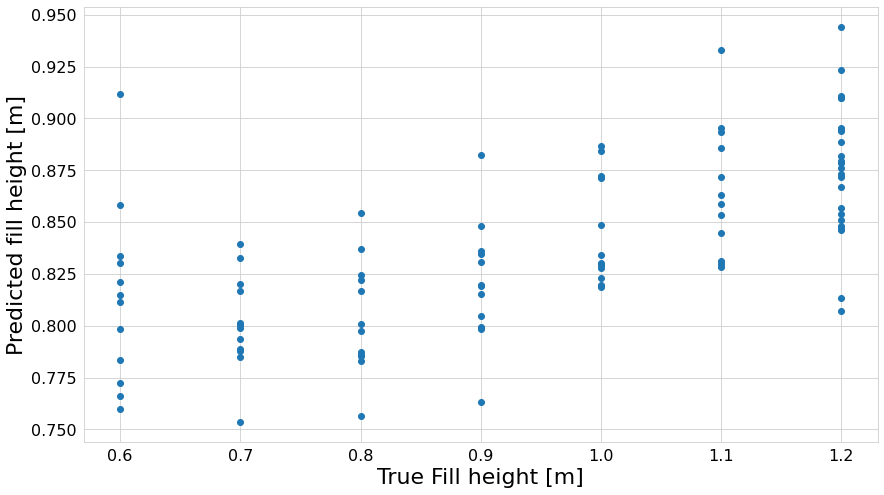

In [34]:
with sns.axes_style(**STYLE):
    plt.figure(figsize=(W_MID, H_MID))
    plt.suptitle("Figure 1", fontsize=LBL_SZ, color=LBL_COL)
    plt.scatter(df_start.gen_target, df_start.pred)
    plt.xlabel('True Fill height [m]', fontsize=LBL_SZ, color=LBL_COL)
    plt.ylabel('Predicted fill height [m]', fontsize=LBL_SZ, color=LBL_COL)
    plt.xticks(fontsize=TK_SZ, color=TK_COL)
    plt.yticks(fontsize=TK_SZ, color=TK_COL)

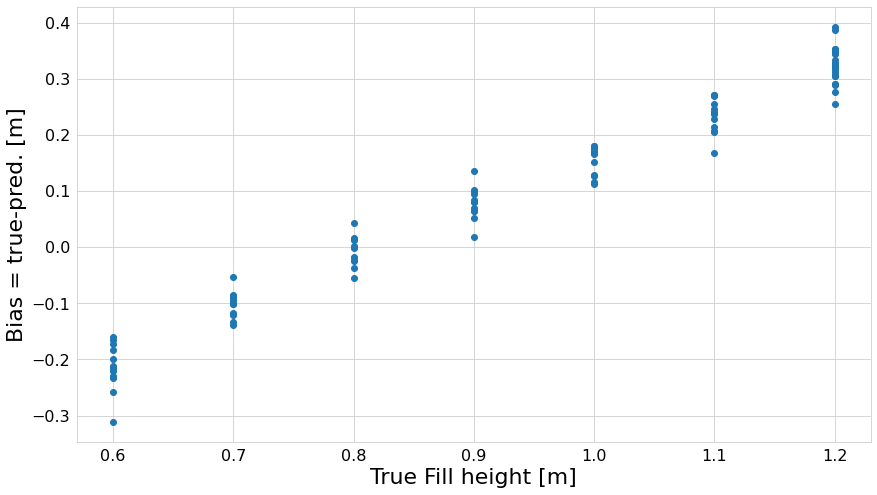

In [35]:
with sns.axes_style(**STYLE):
    plt.figure(figsize=(W_MID, H_MID))
    plt.suptitle("Figure 2", fontsize=LBL_SZ, color=LBL_COL)
    plt.scatter(df_start.gen_target, df_start.bias)
    plt.xlabel('True Fill height [m]', fontsize=LBL_SZ, color=LBL_COL)
    plt.ylabel('Bias = true-pred. [m]', fontsize=LBL_SZ, color=LBL_COL)
    plt.xticks(fontsize=TK_SZ, color=TK_COL)
    plt.yticks(fontsize=TK_SZ, color=TK_COL)

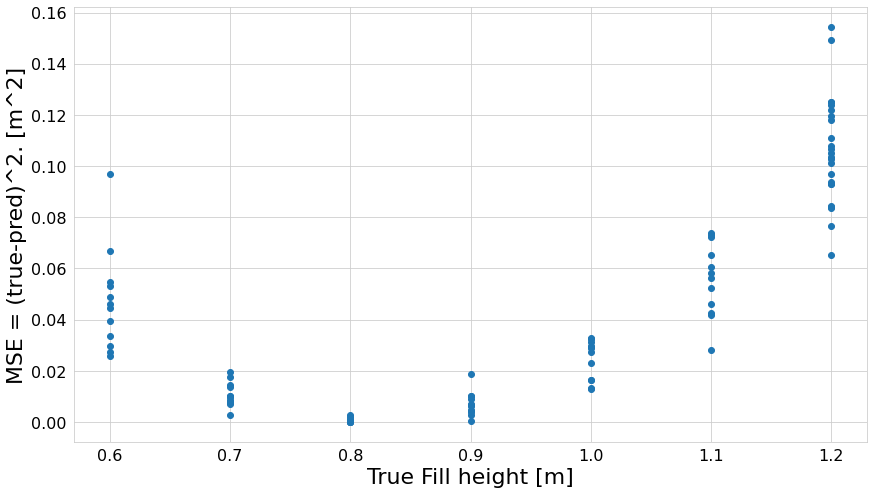

In [36]:
with sns.axes_style(**STYLE):
    plt.figure(figsize=(W_MID, H_MID))
    plt.suptitle("Figure 3", fontsize=LBL_SZ, color=LBL_COL)
    plt.scatter(df_start.gen_target, df_start.mse)
    plt.xlabel('True Fill height [m]', fontsize=LBL_SZ, color=LBL_COL)
    plt.ylabel('MSE = (true-pred)^2. [m^2]', fontsize=LBL_SZ, color=LBL_COL)
    plt.xticks(fontsize=TK_SZ, color=TK_COL)
    plt.yticks(fontsize=TK_SZ, color=TK_COL)

### **E - Bias correction**


Looking at Figure 1, we can see that the predictions for varying true fill-heights are quite indistinguishable due to their spread, and are also biased. We can attempt to correct for this bias using a linear rescaling of the predictions.

Let's grab the predicted and true fill-heights and fit a linear function to them.

In [37]:
from torch import nn, Tensor

In [38]:
x = Tensor(df_start.pred.values)[:,None]
y = Tensor(df_start.gen_target.values)[:,None]

In [39]:
corr_layer = nn.Linear(1,1)
corr_layer.weight.data[0] = 1.0
corr_layer.bias.data[0] = 0.0

In [40]:
opt = torch.optim.SGD(corr_layer.parameters(), lr=3e-1)
mse = nn.MSELoss()

In [41]:
for i in range(10000):
    y_pred = corr_layer(x)
    loss = mse(y_pred, y)
    opt.zero_grad()
    loss.backward()
    opt.step()
print(loss)

tensor(0.0255, grad_fn=<MseLossBackward0>)


In [42]:
corr_layer.weight, corr_layer.bias

(Parameter containing:
 tensor([[3.2857]], requires_grad=True),
 Parameter containing:
 tensor([-1.8156], requires_grad=True))

Now we can use the correction to debias the raw predictions. The effectiveness of this debiassing process depends heavily on how well separated the predictions are for different true fill-heights.

In [43]:
df_start['new_pred'] = corr_layer(Tensor(df_start.pred.values[:,None])).detach().cpu().numpy()
df_start['new_bias'] = df_start.gen_target-df_start.new_pred
df_start['new_mse'] = df_start.new_bias**2

In [44]:
df_start.new_mse.mean(), df_start.new_bias.abs().mean()

(0.025487527, 0.12597995)

In [45]:
from tomopt.benchmarks.ladle_furnace import compare_raw_init_to_bias_corrected_init

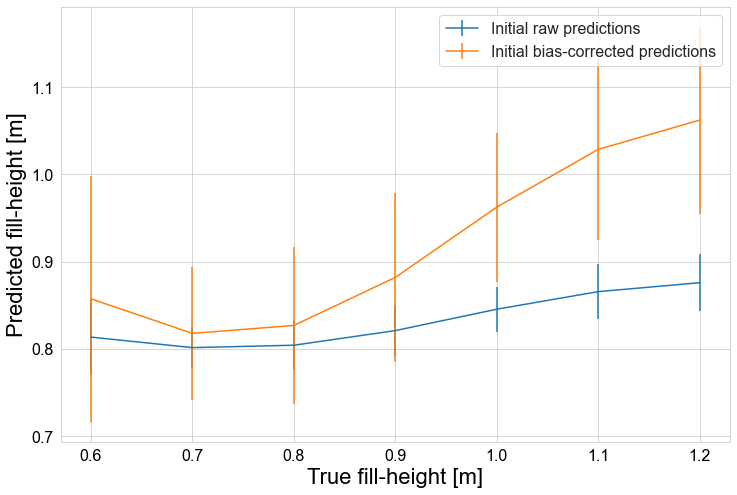

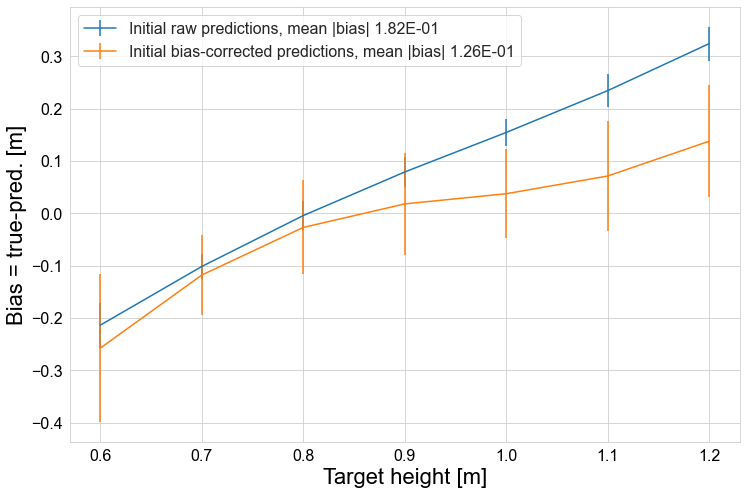

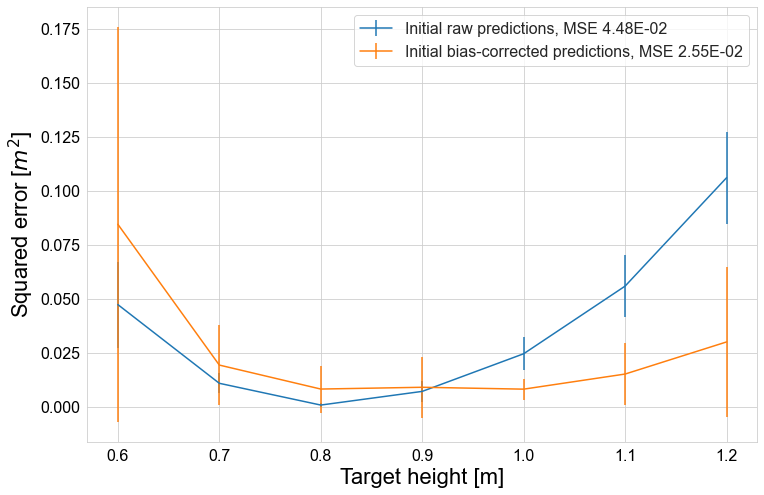

In [46]:
compare_raw_init_to_bias_corrected_init(df_start, NAME)

So, the linear rescaling process was able to reduce the bias, at the cost of an increase in variance, however there is a slight overall decrease in the MSE.

## **II - First optimisation**

Now we want to try to **optimise** the detector to **improve** the **fill-height prediction**. As the **predictions change**, so will the **bias-correction** that should be applied to them, so we'll use a callback to refit the bias correction after every update to the detector.

In [47]:
from tomopt.benchmarks.ladle_furnace import LinearCorrectionCallback

### **A - Optimisation setup**

We don't have a good idea about what **learning rates** will be suitable for optimisation of the parameters, however we can have an reasonable guess about how much each update should correspond to in **physical units**, so by monitoring the loss-gradients received by the parameters, we can estimate suitable learning rates that correspond to the desired update. We'll aim for **1cm updates** for the xyz parameters.

In [48]:
from tomopt.optimisation import OptConfig

In [49]:
opt_config = OptConfig(n_warmup=5, rates={'budget_weights':0.1,'xy_pos_upper':0.01, 'z_pos_upper':0.01, 'xy_pos_lower':0.01, 'z_pos_lower':0.01})

The **loss function** we use is also described in our paper, and aims to quantify how different predictions generally are for different fill-heights. Having **predictions** be **monotonic** with **true fill-height**, and be easily **distinguishable** makes the debiassing process easier.

We'll run the warm-up optimisation for 5 epochs to get an idea of suitable learning rates for our optimisers. During this time, the detectors won't update.

In [50]:
from tomopt.benchmarks.ladle_furnace import SpreadRangeLoss
from tomopt.optimisation import NoMoreNaNs, PanelCentring, PanelMetricLogger

In [52]:
linear_correction = LinearCorrectionCallback(partial(torch.optim.SGD, lr=3e-1), init_weight=corr_layer.weight.item(), init_bias=corr_layer.bias.item())

1 warmup callbacks found, with a total warmup period of 5 epochs.


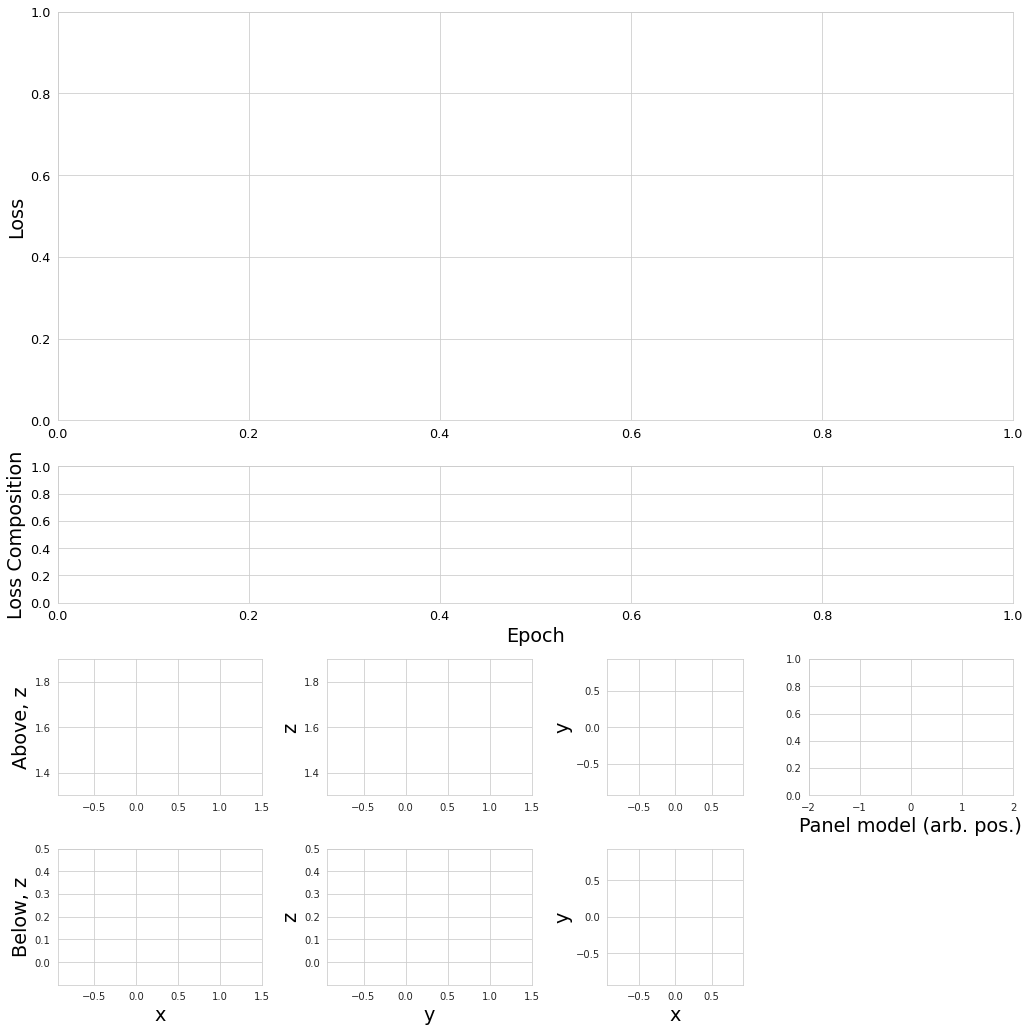

Automatically setting cost coefficient to 0.005253008101135492
OptConfig: Optimiser warm-up completed
+----------------+-------------+-----------------------+
|     Param      | Median Grad |           LR          |
+----------------+-------------+-----------------------+
| budget_weights | 0.028011046 |   3.570020153852333   |
|  xy_pos_upper  | 0.116281755 |  0.08599801384923361  |
|  z_pos_upper   |   34.21903  | 0.0002922350647073296 |
|  xy_pos_lower  | 0.050089918 |  0.19964097335174785  |
|  z_pos_lower   |  27.289982  | 0.0003664348352403338 |
+----------------+-------------+-----------------------+


<Figure size 1024x1024 with 0 Axes>

In [53]:
_ = wrapper.fit(n_epochs=5,
                passive_bs=len(trn_passives),
                n_mu_per_volume=1000,
                mu_bs=250,
                trn_passives=trn_passives,
                val_passives=None,
                cbs=[MuonResampler(), linear_correction, SpreadRangeLoss(), NoMoreNaNs(),
                     opt_config,
                     PanelCentring(), PanelMetricLogger()])

In [54]:
opt_config.lrs

{'budget_weights': 3.570020153852333,
 'xy_pos_upper': 0.08599801384923361,
 'z_pos_upper': 0.0002922350647073296,
 'xy_pos_lower': 0.19964097335174785,
 'z_pos_lower': 0.0003664348352403338}

opt_config.lrs = {'budget_weights': 3.570020153852333,
 'xy_pos_upper': 0.08599801384923361,
 'z_pos_upper': 0.0002922350647073296,
 'xy_pos_lower': 0.19964097335174785,
 'z_pos_lower': 0.0003664348352403338}

From the warm-up learning rate search, we have settings for the optimiser that should correspond to the desired update rates. For the actual training, we'll use a **learning rate schedule** called `OneCycle`, which requires three settings for the learning rates at different stages of training. We'll set these based on the results of the learning-rate search. 

In case anything goes wrong in the optimisation, we'll save a copy of the detector after every epoch. Additionally, we can expect the smoothness of the differentiable model of the detectors to have an impact on the performance. We'll use a callback to adjust it during optimisation such that it begins very smooth (and is sensitive to xy-location) and gradually adjust it such that it becomes more physical (lessens sensitivity to xy-position, and increases sensitivity to z-position).

The initial differentiable model has the following model:

In [ ]:
panel_0 = volume.layers[0].panels[0]

def plot_panel_model(p):

    x = torch.linspace(-1.5,1.5, 100)
    xs = torch.stack([x] * 2, dim=1)

    model = p.sig_model(xs)[:,0].detach().numpy()

    def rect_func(x, xmin, xmax):

        return np.where((x<xmin)|(x>xmax), 0, 1)
    
    fig, ax = plt.subplots()
    fig.suptitle("Detector model with smoothness {}".format(p.smooth.numpy()[0]))
    ax.plot(x.numpy(), model, label="Differentiable model")
    ax.plot(x.numpy(), rect_func(x.numpy(), 
                                xmin = p.xy.detach().numpy()[0] - p.xy_span.detach().numpy()[0]/2, 
                                xmax = p.xy.detach().numpy()[0] + p.xy_span.detach().numpy()[0]/2), 
                                label="Realistic model")
    ax.grid("on")
    ax.set_xlabel("x [m]")
    ax.set_ylabel("Detector model")
    ax.legend()
    plt.show()

plot_panel_model(panel_0)

### **B - Optimisation**

In [66]:
from pathlib import Path
from tomopt.optimisation import  EpochSave, OneCycle, SigmoidPanelSmoothnessSchedule

0 warmup callbacks found, with a total warmup period of 0 epochs.


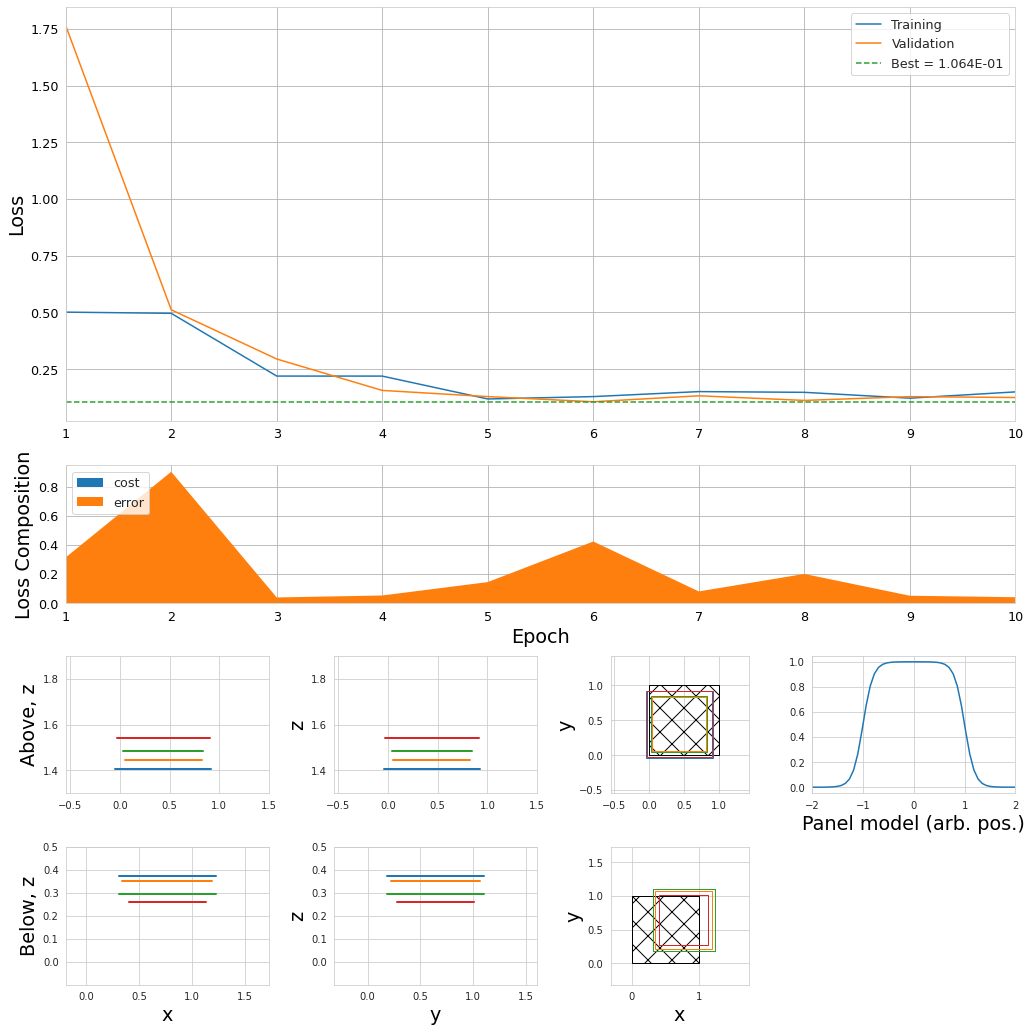

/Users/giles/cernbox/mode_muon_tomography/tomopt/optimisation/callbacks/monitors.py:219: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(1 / self.n_trn_batches, x[-1])


<Figure size 1024x1024 with 0 Axes>

In [68]:
_ = wrapper.fit(n_epochs=10,
                passive_bs=len(trn_passives),
                n_mu_per_volume=1000,
                mu_bs=250,
                trn_passives=trn_passives,
                val_passives=trn_passives,
                cb_savepath=Path(f'train_weights_{NAME}_1'),
                cbs=[EpochSave(),
                    OneCycle('xy_pos_upper', warmup_length=5, init_lr=2*opt_config.lrs['xy_pos_upper'], mid_lr=10*opt_config.lrs['xy_pos_upper'], final_lr=opt_config.lrs['xy_pos_upper']/5),
                    OneCycle('z_pos_upper', warmup_length=5, init_lr=2*opt_config.lrs['z_pos_upper'], mid_lr=10*opt_config.lrs['z_pos_upper'], final_lr=opt_config.lrs['z_pos_upper']),
                    OneCycle('xy_pos_lower', warmup_length=5, init_lr=2*opt_config.lrs['xy_pos_lower'], mid_lr=10*opt_config.lrs['xy_pos_lower'], final_lr=opt_config.lrs['xy_pos_lower']/5),
                    OneCycle('z_pos_lower', warmup_length=5, init_lr=2*opt_config.lrs['z_pos_lower'], mid_lr=10*opt_config.lrs['z_pos_lower'], final_lr=opt_config.lrs['z_pos_lower']),
                    OneCycle('budget_weights', warmup_length=5, init_lr=opt_config.lrs['budget_weights'], mid_lr=2*opt_config.lrs['budget_weights'], final_lr=opt_config.lrs['budget_weights']/2),
                     SigmoidPanelSmoothnessSchedule((1.0, 0.1)),
                     MuonResampler(), linear_correction, SpreadRangeLoss(), NoMoreNaNs(), PanelCentring(), PanelMetricLogger()])

wrapper.load(f'train_weights_{NAME}_1/volume_state_11.pt')

Form this, we can see that the optimisation quickly moved the panels towards the centre of the passive volume, which is what we'd generally expect. Let's save a copy of the detector. N.B. If your detector diverged, you can use the above code to load the state at a well-performing epoch.

In [71]:
wrapper.save(f'train_weights_{NAME}_1/saved.pt')

In [72]:
volume

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.4346, 0.4413]), z=tensor([1.4083]), and xy span tensor([0.9658, 0.9658]) with budget scale 1.2073053121566772
        (1): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.4346, 0.4413]), z=tensor([1.4453]), and xy span tensor([0.7725, 0.7725]) with budget scale 0.9656482934951782
        (2): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.4346, 0.4413]), z=tensor([1.4847]), and xy span tensor([0.8012, 0.8012]) with budget scale 1.001476764678955
        (3): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.4346, 0.4413]), z=tensor([1.5413]), and xy span tensor([0.9377, 0.9377]) with budget scale 1.1720637083053589
      )
    )
    (1): PassiveLayer located at z=tensor([1.4000])
    (2): PassiveLayer located at z=tensor([1.3000])
  

In [ ]:
volume.draw(xlim=(-2,2), ylim=(-2,2), zlim=(-2,2))

### **C - Inference and bias correction**

Now let's evaluate the **performance** of the **optimised detector**.

for l in volume.get_detectors():
    for p in l.panels:
        p.smooth = torch.tensor(0.1)

wrapper.load(f'train_weights_{NAME}_1/saved.pt')

In [73]:
preds = wrapper.predict(test_passives,
                        n_mu_per_volume=1000,
                        mu_bs=1000,
                        pred_cb=VolumeTargetPredHandler(),
                        cbs=[MuonResampler(), linear_correction])

In [76]:
df_opt = pd.DataFrame(np.array(preds).flatten().reshape(-1,2), columns=['pred', 'gen_target'])
df_opt['gen_target'] = volume.passive_size*((df_opt.gen_target/volume.passive_size)//1)
df_opt['bias'] = (df_opt.gen_target-df_opt.pred)
df_opt['mse'] = df_opt.bias**2

In [77]:
df_opt.mse.mean()

0.006848768

We'll go through the usual debiasing process

In [78]:
x = Tensor(df_opt.pred.values)[:,None]
y = Tensor(df_opt.gen_target.values)[:,None]

In [79]:
corr_layer = nn.Linear(1,1)
corr_layer.weight.data[0] = 1.0
corr_layer.bias.data[0] = 0.0

In [80]:
opt = torch.optim.SGD(corr_layer.parameters(), lr=3e-1)
mse = nn.MSELoss()

In [81]:
for i in range(10000):
    y_pred = corr_layer(x)
    loss = mse(y_pred, y)
    opt.zero_grad()
    loss.backward()
    opt.step()
print(loss)

tensor(0.0020, grad_fn=<MseLossBackward0>)


In [82]:
corr_layer.weight, corr_layer.bias

(Parameter containing:
 tensor([[0.7637]], requires_grad=True),
 Parameter containing:
 tensor([0.2428], requires_grad=True))

And to be safe, we'll recompute predictions on a new test set

In [83]:
preds = wrapper.predict(test_passives,
                        n_mu_per_volume=1000,
                        mu_bs=1000,
                        pred_cb=VolumeTargetPredHandler(),
                        cbs=[MuonResampler(), linear_correction])

In [84]:
df_opt = pd.DataFrame(np.array(preds).flatten().reshape(-1,2), columns=['pred', 'gen_target'])
df_opt['gen_target'] = volume.passive_size*((df_opt.gen_target/volume.passive_size)//1)
df_opt['new_pred'] = corr_layer(Tensor(df_opt.pred.values[:,None])).detach().cpu().numpy()
df_opt['new_bias'] = df_opt.gen_target-df_opt.new_pred
df_opt['new_mse'] = df_opt.new_bias**2

In [85]:
df_opt.new_mse.mean(), df_opt.new_bias.abs().mean()

(0.0016529355, 0.032161165)

In [86]:
from tomopt.benchmarks.ladle_furnace import compare_init_to_optimised

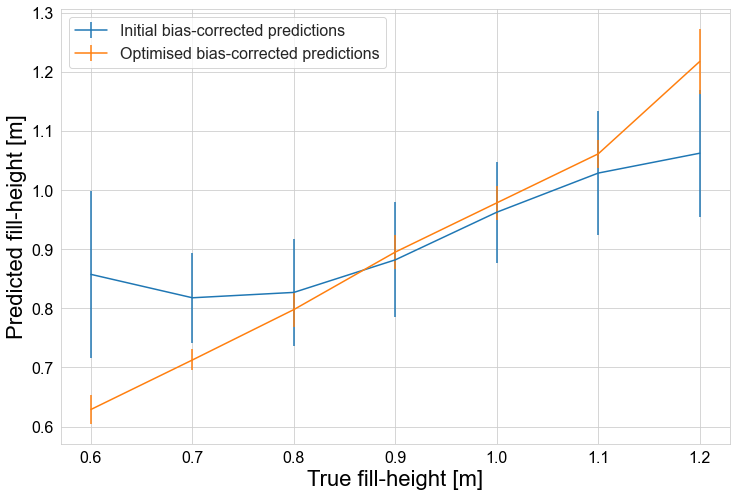

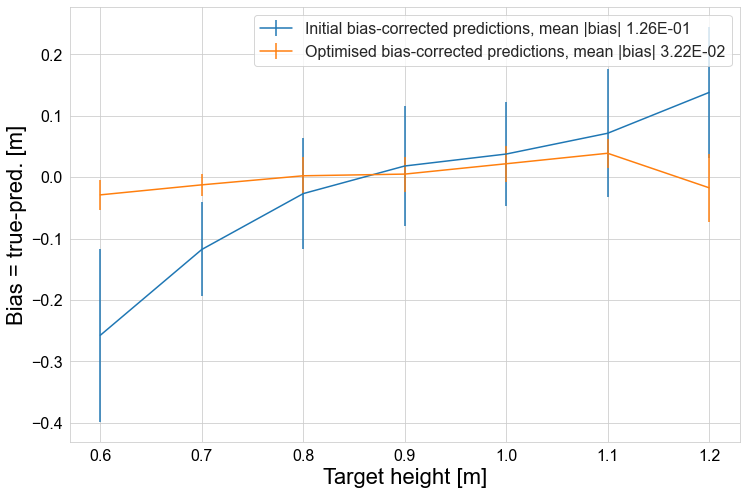

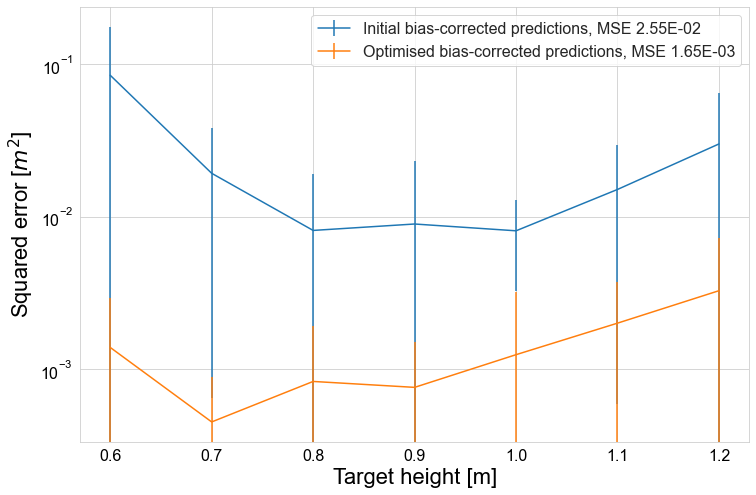

In [87]:
compare_init_to_optimised(df_start=df_start, df_opt=df_opt, NAME=NAME)

So, the optimised detector definitely improves on the starting detector. Let's see if we can further refine it.

## **III - Second optimisation**

wrapper.load(f'train_weights_{NAME}_1/saved.pt')

We saw that the panels generally **moved** to be located **above** and **below** the passive volume. Since it's unlikely the optimisation will be able to perfectly centralise the panels, let's use our domain knowledge about the **symmetry** of the problem to **assume** that the **optimal positions** are **directly above** and **below** the volume. 

For the refinement, we'll then aim to just **learn** the **optimal z-positions** of the **detectors**, and associated **sizes**.

In [88]:
for l in volume.get_detectors():
    for p in l.panels:
        p.xy.data = Tensor([0.5,0.5])
        p.smooth = torch.tensor(0.1)

In [89]:
volume

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.4083]), and xy span tensor([0.9658, 0.9658]) with budget scale 1.2073053121566772
        (1): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.4453]), and xy span tensor([0.7725, 0.7725]) with budget scale 0.9656482934951782
        (2): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.4847]), and xy span tensor([0.8012, 0.8012]) with budget scale 1.001476764678955
        (3): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.5413]), and xy span tensor([0.9377, 0.9377]) with budget scale 1.1720637083053589
      )
    )
    (1): PassiveLayer located at z=tensor([1.4000])
    (2): PassiveLayer located at z=tensor([1.3000])
  

In [90]:
linear_correction = LinearCorrectionCallback(partial(torch.optim.SGD, lr=3e-1), init_weight=corr_layer.weight.item(), init_bias=corr_layer.bias.item())

In [91]:
opt_config = OptConfig(n_warmup=5, rates={'z_pos_upper':0.01, 'z_pos_lower':0.01, 'budget_weights':0.1})

In [92]:
wrapper.set_opt_lr(0.0, 'xy_pos_upper')
wrapper.set_opt_lr(0.0, 'xy_pos_lower')

### **A - Optimisation setup**

Again, we'll rerun the learning rate finder, since the detectors have changed quite a bit since we first ran it.

1 warmup callbacks found, with a total warmup period of 5 epochs.


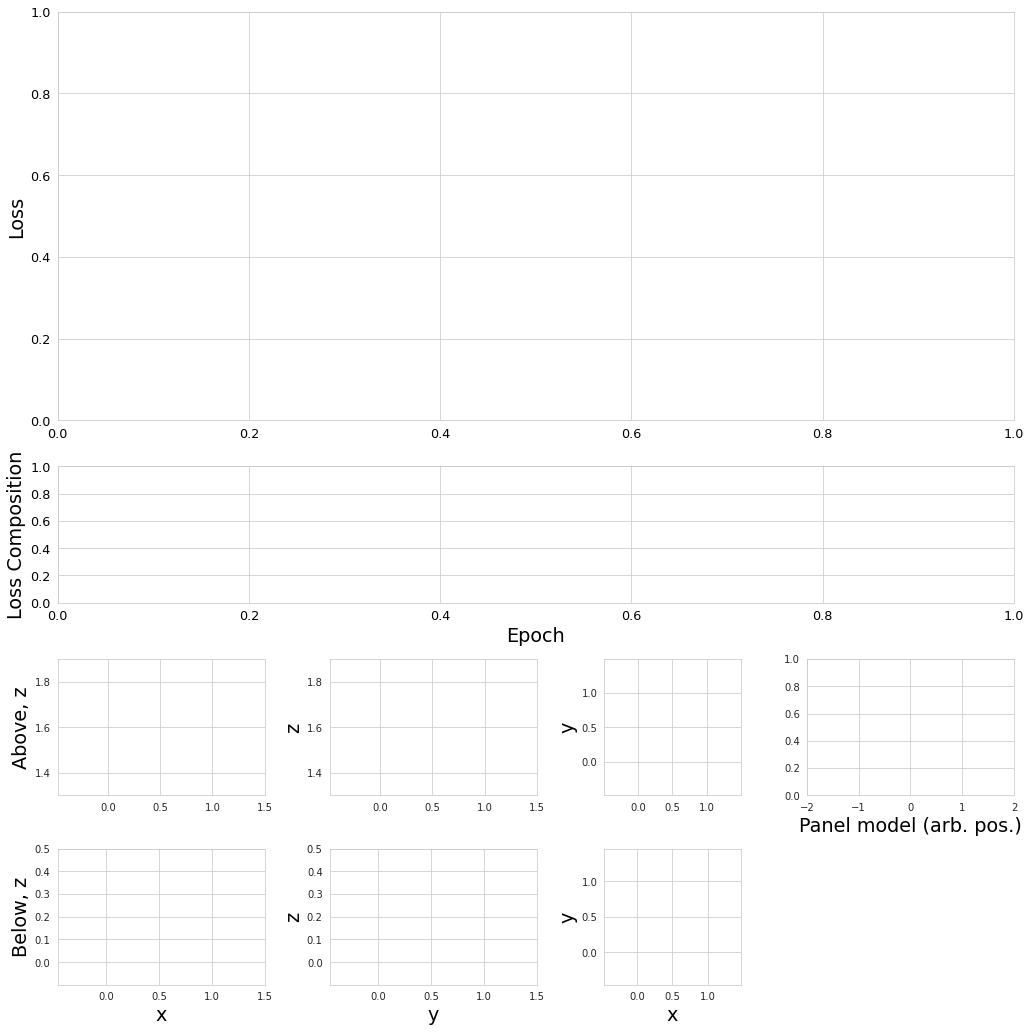

OptConfig: Optimiser warm-up completed
+----------------+--------------+----------------------+
|     Param      | Median Grad  |          LR          |
+----------------+--------------+----------------------+
|  z_pos_upper   |  1.9098995   | 0.00523587766810362  |
|  z_pos_lower   |   1.589889   | 0.006289747075719527 |
| budget_weights | 0.0047855163 |  20.89638687772811   |
+----------------+--------------+----------------------+


<Figure size 1024x1024 with 0 Axes>

In [94]:
_ = wrapper.fit(n_epochs=5,
                passive_bs=len(trn_passives),
                n_mu_per_volume=1000,
                mu_bs=250,
                trn_passives=trn_passives,
                val_passives=None,
                cbs=[MuonResampler(), linear_correction, SpreadRangeLoss(), NoMoreNaNs(),
                     opt_config,
                     PanelCentring(), PanelMetricLogger()])

In [95]:
opt_config.lrs

{'z_pos_upper': 0.00523587766810362,
 'z_pos_lower': 0.006289747075719527,
 'budget_weights': 20.89638687772811}

opt_config.lrs = {'z_pos_upper': 0.00523587766810362,
 'z_pos_lower': 0.006289747075719527,
 'budget_weights': 20.89638687772811}

In [96]:
wrapper.set_opt_lr(0.0, 'xy_pos_upper')
wrapper.set_opt_lr(0.0, 'xy_pos_lower')

### **B - Optimisation**

0 warmup callbacks found, with a total warmup period of 0 epochs.


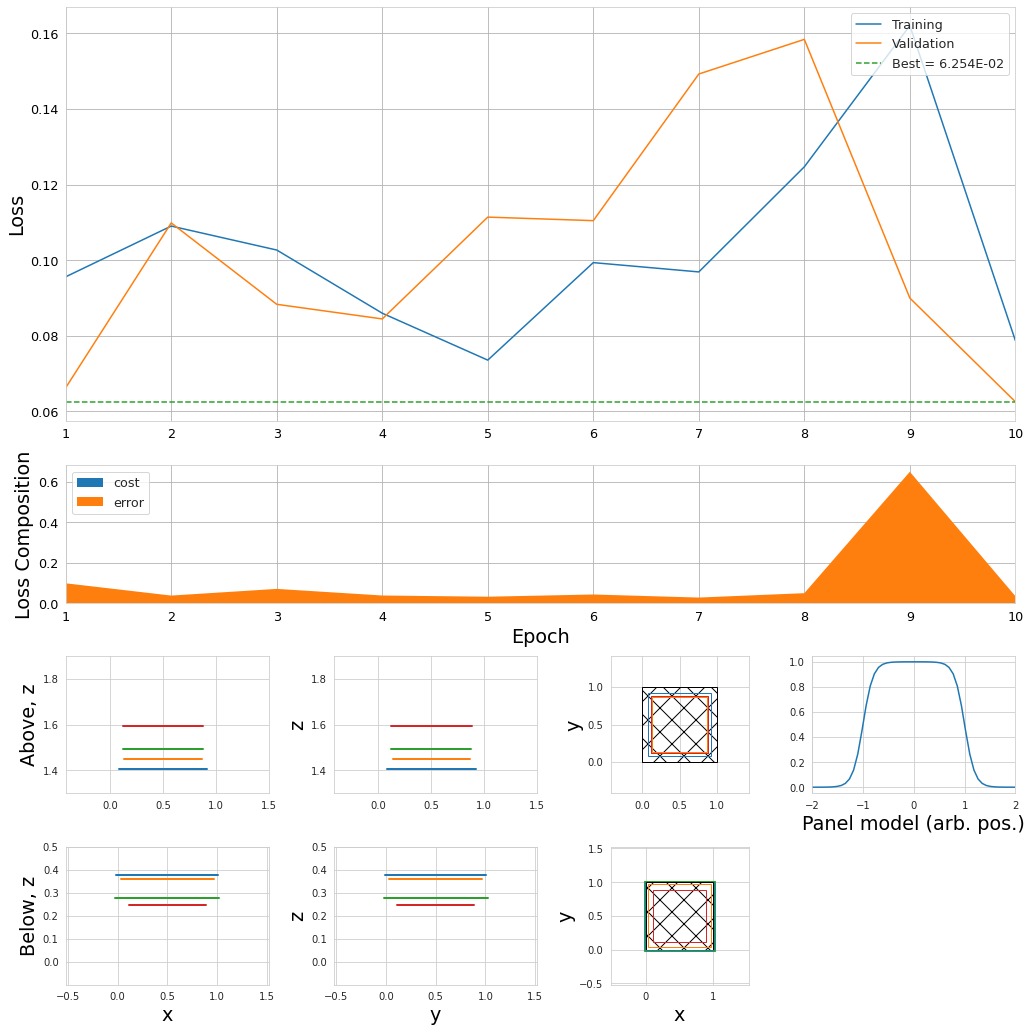

/Users/giles/cernbox/mode_muon_tomography/tomopt/optimisation/callbacks/monitors.py:219: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(1 / self.n_trn_batches, x[-1])


<Figure size 1024x1024 with 0 Axes>

In [98]:
_ = wrapper.fit(n_epochs=10,
                passive_bs=len(trn_passives),
                n_mu_per_volume=1000,
                mu_bs=250,
                trn_passives=trn_passives,
                val_passives=trn_passives,
                
                cb_savepath=Path(f'train_weights_{NAME}_2'),
                cbs=[EpochSave(),
                    OneCycle('z_pos_upper', warmup_length=1, init_lr=opt_config.lrs['z_pos_upper'], mid_lr=opt_config.lrs['z_pos_upper'], final_lr=opt_config.lrs['z_pos_upper']/2),
                    OneCycle('z_pos_lower', warmup_length=1, init_lr=opt_config.lrs['z_pos_lower'], mid_lr=opt_config.lrs['z_pos_lower'], final_lr=opt_config.lrs['z_pos_lower']/2),
                    OneCycle('budget_weights', warmup_length=1, init_lr=opt_config.lrs['budget_weights']/10, mid_lr=opt_config.lrs['budget_weights']/10, final_lr=opt_config.lrs['budget_weights']/20),
                     MuonResampler(), linear_correction, SpreadRangeLoss(), NoMoreNaNs(), PanelCentring(), PanelMetricLogger()])

In [99]:
volume

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.4053]), and xy span tensor([0.8376, 0.8376]) with budget scale 1.0470285415649414
        (1): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.4487]), and xy span tensor([0.7317, 0.7317]) with budget scale 0.9146248698234558
        (2): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.4913]), and xy span tensor([0.7542, 0.7542]) with budget scale 0.9427161812782288
        (3): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.5918]), and xy span tensor([0.7629, 0.7629]) with budget scale 0.9536605477333069
      )
    )
    (1): PassiveLayer located at z=tensor([1.4000])
    (2): PassiveLayer located at z=tensor([1.3000])
 

In [ ]:
volume.draw(xlim=(-2,2), ylim=(-2,2), zlim=(-2,2))

In [100]:
wrapper.save(f'train_weights_{NAME}_2/saved.pt')

### **C - Inference and bias correction**

wrapper.load(f'train_weights_{NAME}_2/saved.pt')

In [101]:
preds = wrapper.predict(test_passives,
                        n_mu_per_volume=1000,
                        mu_bs=1000,
                        pred_cb=VolumeTargetPredHandler(),
                        cbs=[MuonResampler(), linear_correction])

In [104]:
df_opt_2 = pd.DataFrame(np.array(preds).flatten().reshape(-1,2), columns=['pred', 'gen_target'])
df_opt_2['gen_target'] = volume.passive_size*((df_opt_2.gen_target/volume.passive_size)//1)
df_opt_2['bias'] = (df_opt_2.gen_target-df_opt_2.pred)
df_opt_2['mse'] = df_opt_2.bias**2

In [105]:
df_opt_2.mse.mean()

0.0037040997

In [106]:
x = Tensor(df_opt_2.pred.values)[:,None]
y = Tensor(df_opt_2.gen_target.values)[:,None]

In [107]:
corr_layer = nn.Linear(1,1)
corr_layer.weight.data[0] = 1.0
corr_layer.bias.data[0] = 0.0

In [108]:
opt = torch.optim.SGD(corr_layer.parameters(), lr=3e-1)
mse = nn.MSELoss()

In [109]:
for i in range(10000):
    y_pred = corr_layer(x)
    loss = mse(y_pred, y)
    opt.zero_grad()
    loss.backward()
    opt.step()
print(loss)

tensor(0.0010, grad_fn=<MseLossBackward0>)


In [110]:
corr_layer.weight, corr_layer.bias

(Parameter containing:
 tensor([[0.8207]], requires_grad=True),
 Parameter containing:
 tensor([0.1892], requires_grad=True))

In [111]:
preds = wrapper.predict(test_passives,
                        n_mu_per_volume=1000,
                        mu_bs=1000,
                        pred_cb=VolumeTargetPredHandler(),
                        cbs=[MuonResampler(), linear_correction])

In [112]:
df_opt_2 = pd.DataFrame(np.array(preds).flatten().reshape(-1,2), columns=['pred', 'gen_target'])
df_opt_2['gen_target'] = volume.passive_size*((df_opt_2.gen_target/volume.passive_size)//1)
df_opt_2['new_pred'] = corr_layer(Tensor(df_opt_2.pred.values[:,None])).detach().cpu().numpy()
df_opt_2['new_bias'] = df_opt_2.gen_target-df_opt_2.new_pred
df_opt_2['new_mse'] = df_opt_2.new_bias**2

In [113]:
df_opt_2.new_mse.mean(), df_opt_2.new_bias.abs().mean()

(0.0011332126, 0.025141058)

In [114]:
from tomopt.benchmarks.ladle_furnace import compare_init_optimised_2

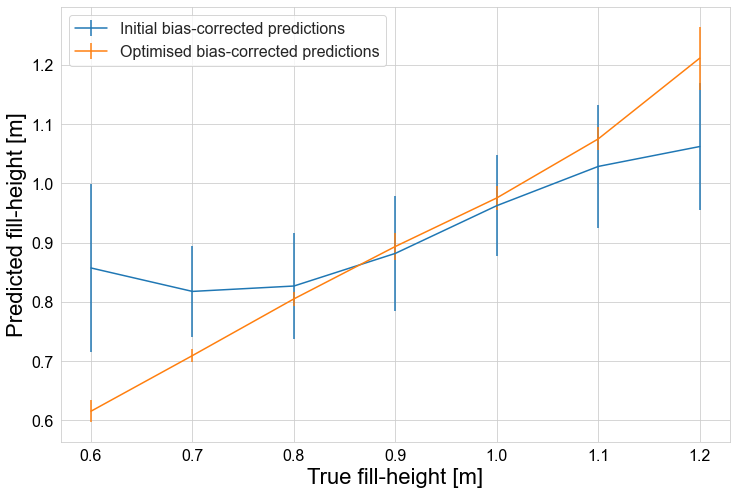

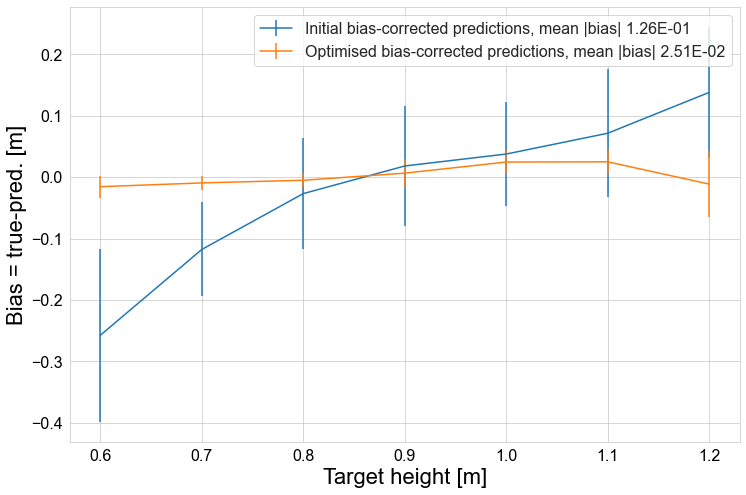

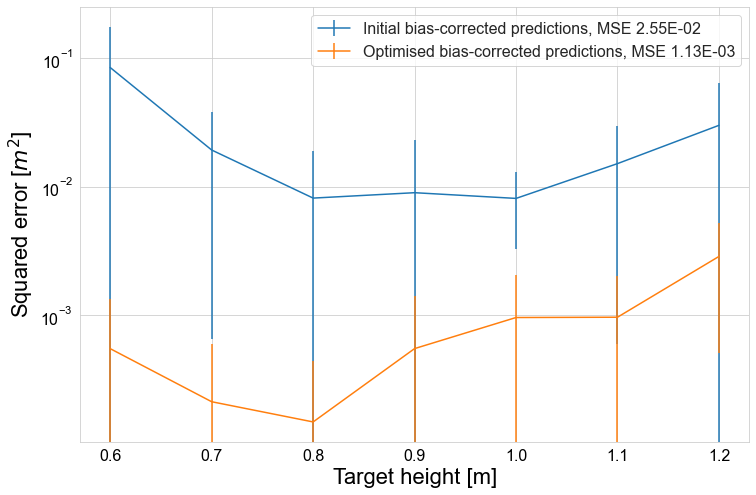

In [115]:
compare_init_optimised_2(df_start=df_start, df_opt_2=df_opt_2, NAME=NAME)

## **IV - Baselines Detector comparision** 

We saw that the **optimisation** was able to **improve** over the initial starting detector, however the initial detector was deliberately designed to have **poor** performance to demonstrate the optimisation procedure. What we are really interested in is whether the **optimiser** is able to arrive at **detectors** that could **match performance** of **human-designed** ones. In this final step, we'll compare against to baseline detectors:

- The first, creates pairs of panels, with a large separation between them, aiming to maximise trajectory reconstruction resolution, whilst ignoring muon efficiency.

- The second distributed panels evenly in space, attempting to perform a trade-off between muon efficiency and trajectory precision.

Both detectors use the same size for every panel.

In [116]:
from tomopt.benchmarks.ladle_furnace import get_baseline_detector_1, get_baseline_detector_2

In [118]:
baseline_1_wrapper = ArbVolumeWrapper(Volume(get_baseline_detector_1(), budget=6),
                             opts=opts,
                             loss_func=VolumeMSELoss(target_budget=None),
                             partial_volume_inferrer=partial(PocaZLadleFurnaceFillLevelInferrer, smooth=1.0))

In [119]:
baseline_1_wrapper.volume

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.8000]), and xy span tensor([0.8660, 0.8660]) with budget scale 1.0825316905975342
        (1): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.7500]), and xy span tensor([0.8660, 0.8660]) with budget scale 1.0825316905975342
        (2): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.5000]), and xy span tensor([0.8660, 0.8660]) with budget scale 1.0825316905975342
        (3): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.4500]), and xy span tensor([0.8660, 0.8660]) with budget scale 1.0825316905975342
      )
    )
    (1): PassiveLayer located at z=tensor([1.4000])
    (2): PassiveLayer located at z=tensor([1.3000])
 

In [ ]:
baseline_1_wrapper.volume.draw(xlim=(-2,2), ylim=(-2,2), zlim=(-2,2))

In [120]:
preds = baseline_1_wrapper.predict(test_passives,
                        n_mu_per_volume=1000,
                        mu_bs=1000,
                        pred_cb=VolumeTargetPredHandler(),
                        cbs=[MuonResampler()])

In [121]:
df_bl_1 = pd.DataFrame(np.array(preds).flatten().reshape(-1,2), columns=['pred', 'gen_target'])
df_bl_1['gen_target'] = baseline_1_wrapper.volume.passive_size*((df_bl_1.gen_target/baseline_1_wrapper.volume.passive_size)//1)

In [122]:
x = Tensor(df_bl_1.pred.values)[:,None]
y = Tensor(df_bl_1.gen_target.values)[:,None]

In [123]:
corr_layer = nn.Linear(1,1)
corr_layer.weight.data[0] = 1.0
corr_layer.bias.data[0] = 0.0

In [124]:
opt = torch.optim.SGD(corr_layer.parameters(), lr=3e-1)
mse = nn.MSELoss()

In [125]:
for i in range(10000):
    y_pred = corr_layer(x)
    loss = mse(y_pred, y)
    opt.zero_grad()
    loss.backward()
    opt.step()
print(loss)

tensor(0.0011, grad_fn=<MseLossBackward0>)


In [126]:
preds = baseline_1_wrapper.predict(test_passives,
                        n_mu_per_volume=1000,
                        mu_bs=1000,
                        pred_cb=VolumeTargetPredHandler(),
                        cbs=[MuonResampler()])

In [127]:
df_bl_1 = pd.DataFrame(np.array(preds).flatten().reshape(-1,2), columns=['pred', 'gen_target'])
df_bl_1['gen_target'] = baseline_1_wrapper.volume.passive_size*((df_bl_1.gen_target/baseline_1_wrapper.volume.passive_size)//1)
df_bl_1['new_pred'] = corr_layer(Tensor(df_bl_1.pred.values[:,None])).detach().cpu().numpy()
df_bl_1['new_bias'] = df_bl_1.gen_target-df_bl_1.new_pred
df_bl_1['new_mse'] = df_bl_1.new_bias**2

In [128]:
baseline_2_wrapper = ArbVolumeWrapper(Volume(get_baseline_detector_2(), budget=6),
                             opts=opts,
                             loss_func=VolumeMSELoss(target_budget=None),
                             partial_volume_inferrer=partial(PocaZLadleFurnaceFillLevelInferrer, smooth=1.0))

In [129]:
baseline_2_wrapper.volume

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.7500]), and xy span tensor([0.8660, 0.8660]) with budget scale 1.0825316905975342
        (1): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.6500]), and xy span tensor([0.8660, 0.8660]) with budget scale 1.0825316905975342
        (2): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.5500]), and xy span tensor([0.8660, 0.8660]) with budget scale 1.0825316905975342
        (3): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.4500]), and xy span tensor([0.8660, 0.8660]) with budget scale 1.0825316905975342
      )
    )
    (1): PassiveLayer located at z=tensor([1.4000])
    (2): PassiveLayer located at z=tensor([1.3000])
 

In [ ]:
baseline_2_wrapper.volume.draw(xlim=(-2,2), ylim=(-2,2), zlim=(-2,2))

In [130]:
preds = baseline_2_wrapper.predict(test_passives,
                        n_mu_per_volume=1000,
                        mu_bs=1000,
                        pred_cb=VolumeTargetPredHandler(),
                        cbs=[MuonResampler()])

In [131]:
df_bl_2 = pd.DataFrame(np.array(preds).flatten().reshape(-1,2), columns=['pred', 'gen_target'])
df_bl_2['gen_target'] = baseline_2_wrapper.volume.passive_size*((df_bl_2.gen_target/baseline_2_wrapper.volume.passive_size)//1)

In [132]:
x = Tensor(df_bl_2.pred.values)[:,None]
y = Tensor(df_bl_2.gen_target.values)[:,None]

In [133]:
corr_layer = nn.Linear(1,1)
corr_layer.weight.data[0] = 1.0
corr_layer.bias.data[0] = 0.0

In [134]:
opt = torch.optim.SGD(corr_layer.parameters(), lr=3e-1)
mse = nn.MSELoss()

In [135]:
for i in range(10000):
    y_pred = corr_layer(x)
    loss = mse(y_pred, y)
    opt.zero_grad()
    loss.backward()
    opt.step()
print(loss)

tensor(0.0011, grad_fn=<MseLossBackward0>)


In [136]:
preds = baseline_2_wrapper.predict(test_passives,
                        n_mu_per_volume=1000,
                        mu_bs=1000,
                        pred_cb=VolumeTargetPredHandler(),
                        cbs=[MuonResampler()])

In [137]:
df_bl_2 = pd.DataFrame(np.array(preds).flatten().reshape(-1,2), columns=['pred', 'gen_target'])
df_bl_2['gen_target'] = baseline_2_wrapper.volume.passive_size*((df_bl_2.gen_target/baseline_2_wrapper.volume.passive_size)//1)
df_bl_2['new_pred'] = corr_layer(Tensor(df_bl_2.pred.values[:,None])).detach().cpu().numpy()
df_bl_2['new_bias'] = df_bl_2.gen_target-df_bl_2.new_pred
df_bl_2['new_mse'] = df_bl_2.new_bias**2

In [138]:
from tomopt.benchmarks.ladle_furnace import compare_optimised_to_baselines

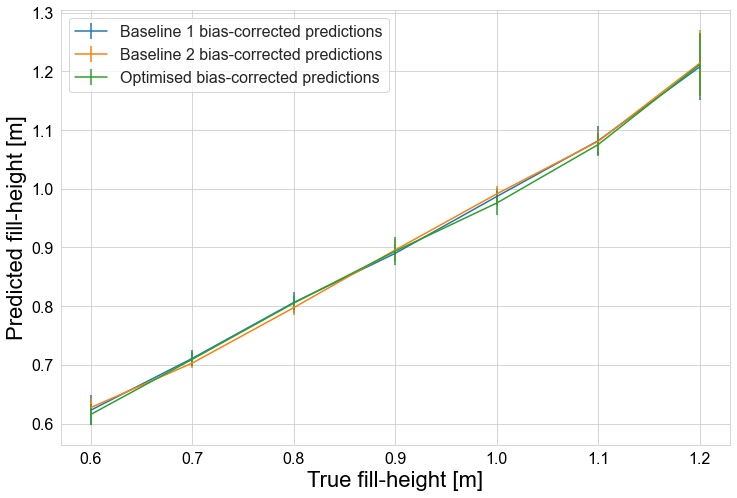

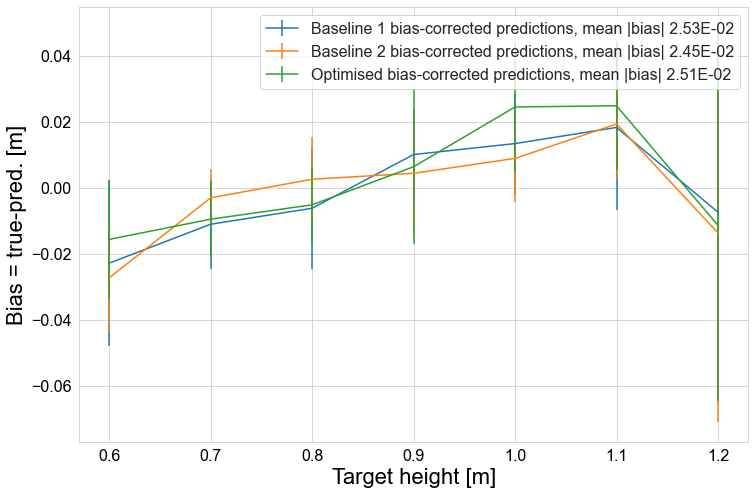

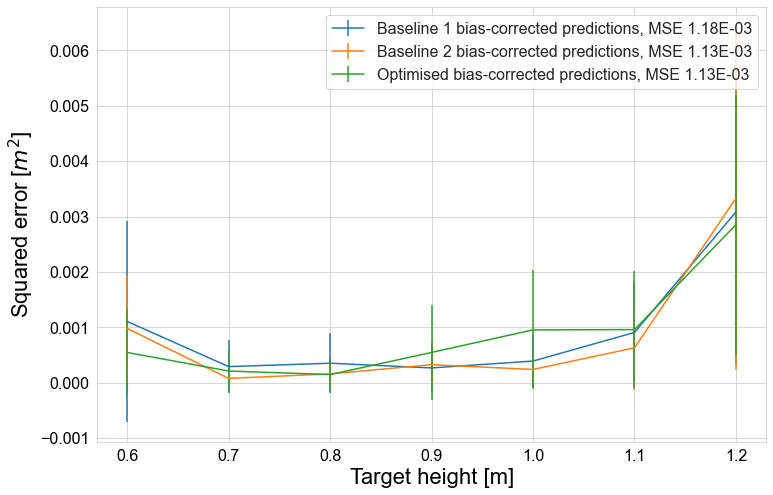

In [139]:
compare_optimised_to_baselines(df_bl_1=df_bl_1, df_bl_2=df_bl_2, df_opt_2=df_opt_2, NAME=NAME)

So, in the end we were able to match the performance of the human-designed detectors, in a mostly-automated fashion.